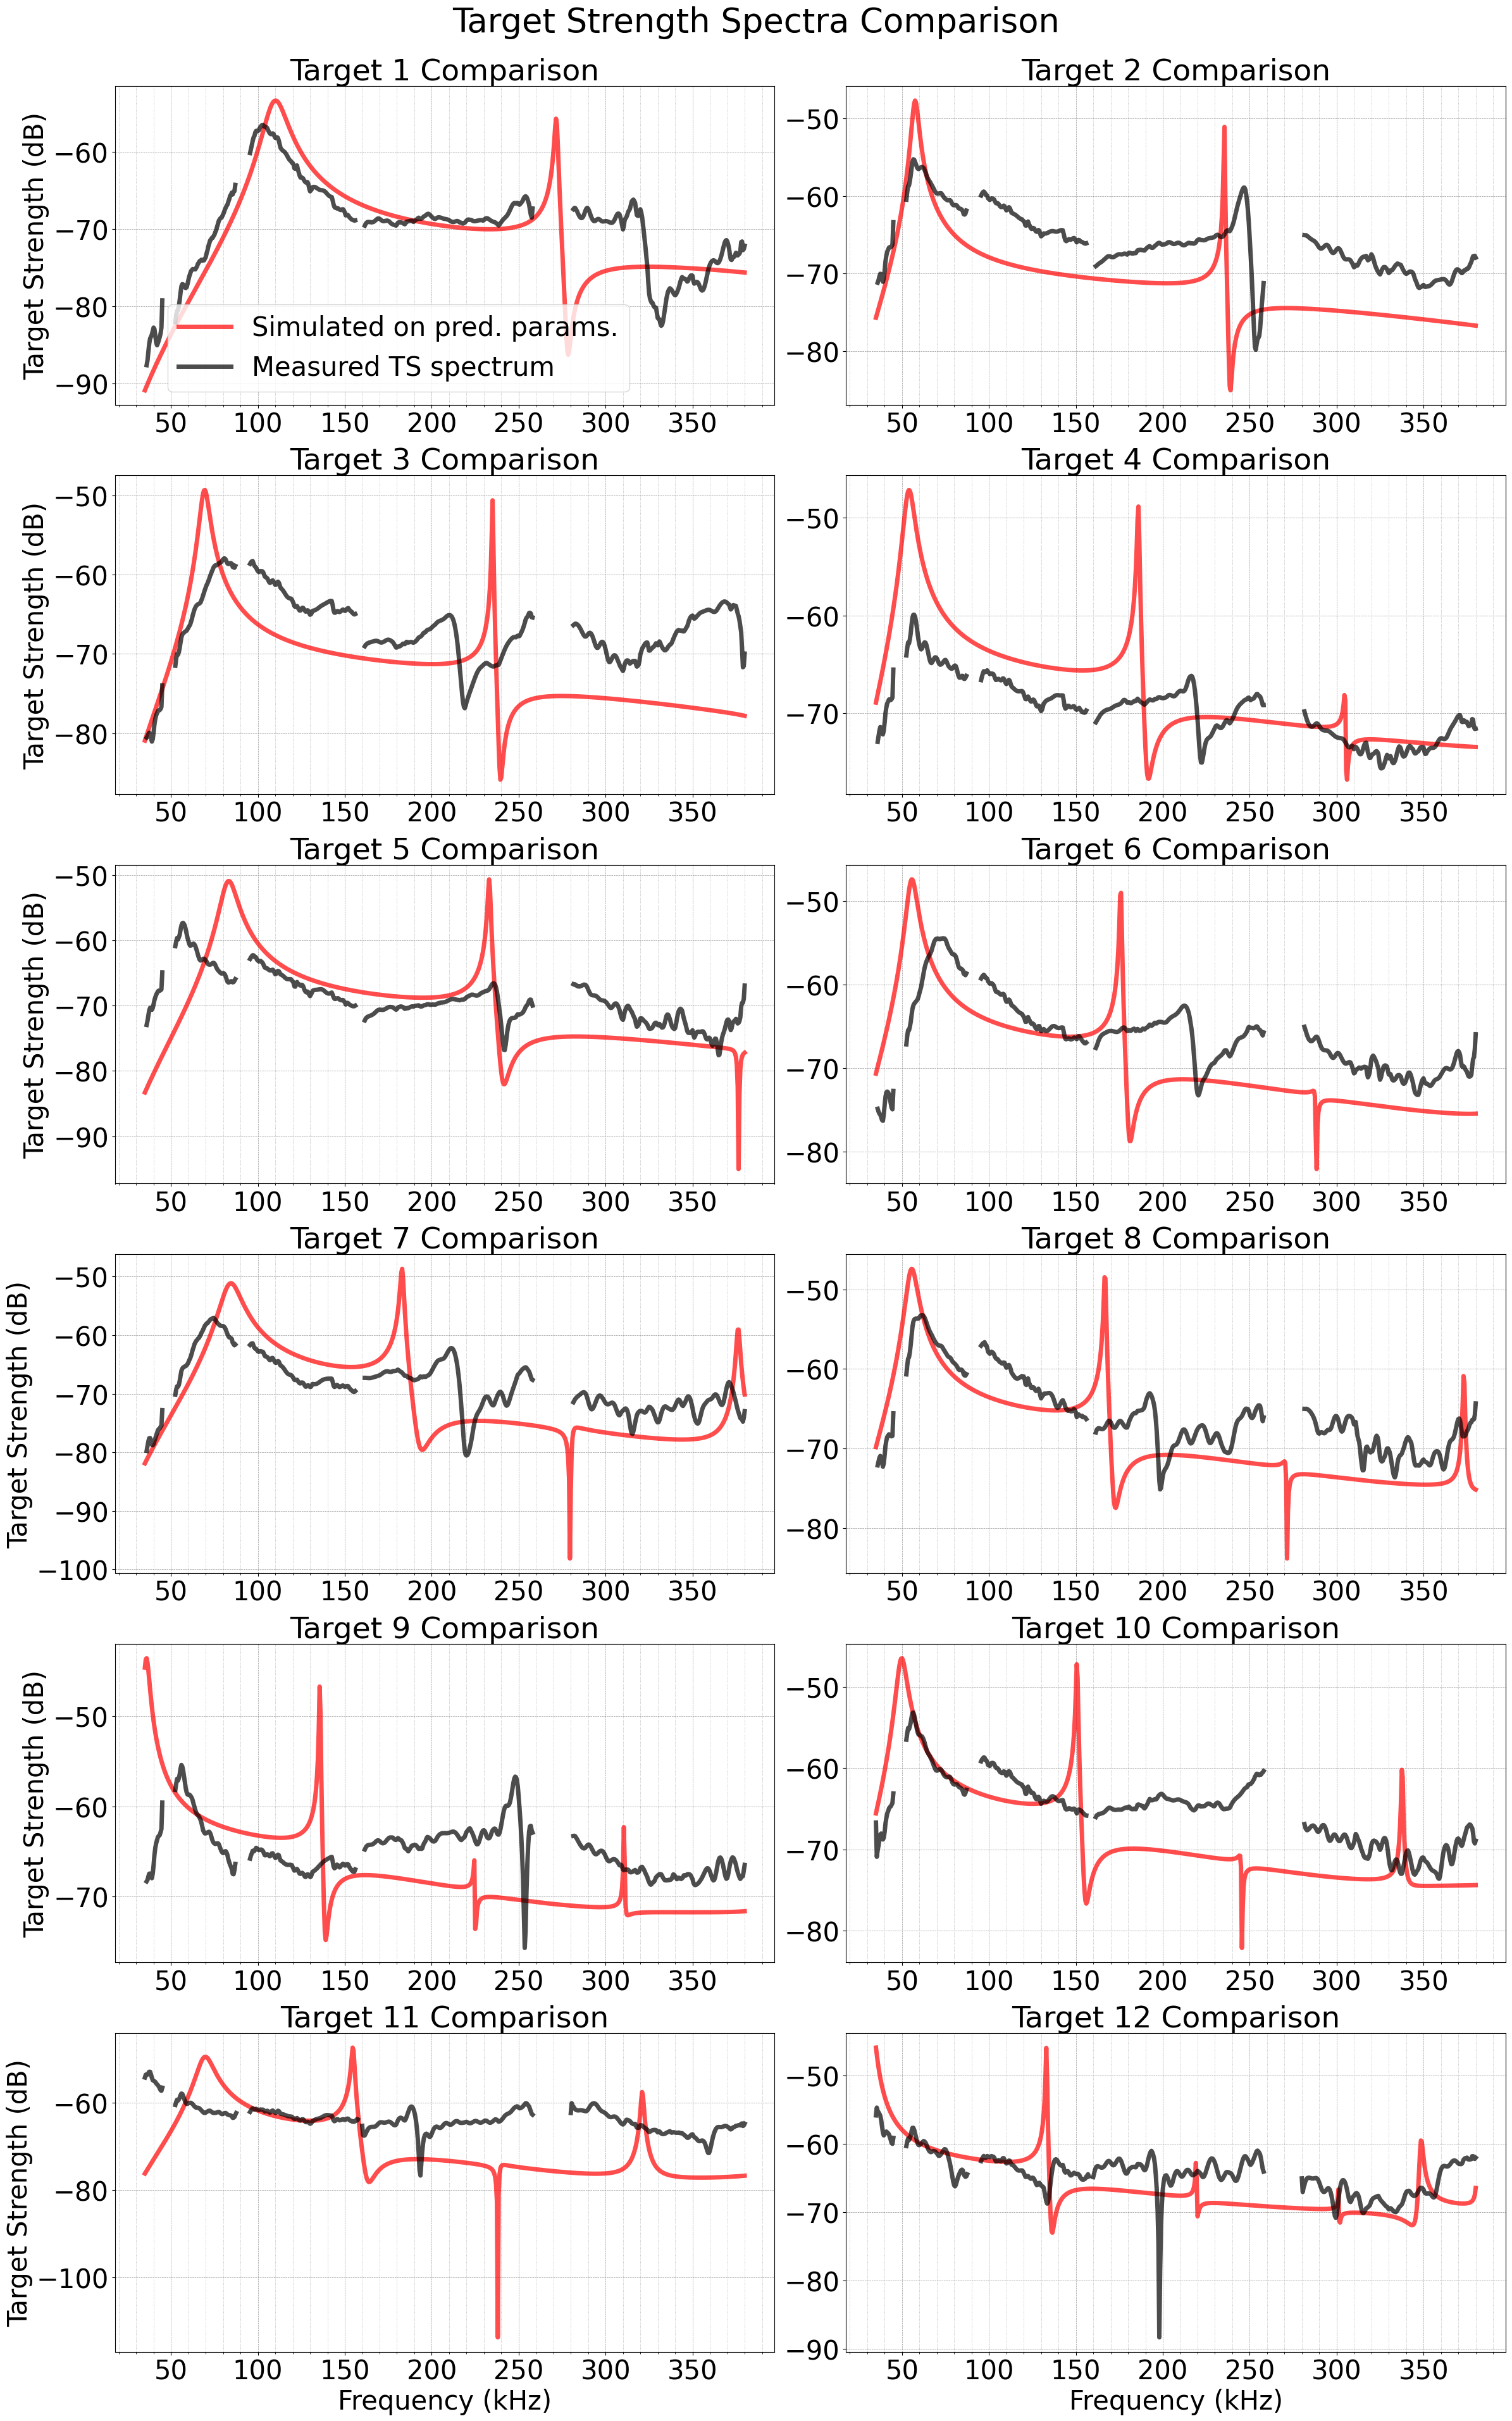

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import os

# Create a figure with a 6x2 grid (12 subplots)
fig, axes = plt.subplots(6, 2, figsize=(24, 39))
fig.suptitle('Target Strength Spectra Comparison', fontsize=38)


def extract_ts_data(df):
    ts_columns = [col for col in df.columns if col.startswith('TS_')]
    frequencies = [float(col.replace('TS_', '')) for col in ts_columns]
    values = df.loc[0, ts_columns].values
    
    # Create a DataFrame and sort by frequency
    data_df = pd.DataFrame({'Frequency': frequencies, 'TS': values})
    return data_df.sort_values('Frequency')


def split_into_continuous_segments(data_df):
    segments = []
    if len(data_df) == 0:
        return segments
    
    current_segment = [data_df.iloc[0]]
    
    for i in range(1, len(data_df)):
        freq_diff = data_df.iloc[i]['Frequency'] - data_df.iloc[i-1]['Frequency']
        if abs(freq_diff - 0.5) < 1e-6:
            current_segment.append(data_df.iloc[i])
        else:
            segments.append(pd.DataFrame(current_segment))
            current_segment = [data_df.iloc[i]]
    
    if current_segment:
        segments.append(pd.DataFrame(current_segment))
    
    return segments

# Plot each target in its own subplot
for i in range(12):
    target_num = i + 1 
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    try:
        # Read each file
        target_file = f'../in_situ_data/predicted_TS_simulated/Target_{target_num}.csv'
        merged_file = f'../in_situ_data/merged_TS_Target_{target_num}.csv'
        
        if os.path.exists(target_file) and os.path.exists(merged_file):
            target = pd.read_csv(target_file)
            merged_target = pd.read_csv(merged_file)
            
            # Extract and process data
            target_data = extract_ts_data(target)
            merged_target_data = extract_ts_data(merged_target)
            
            # Plot original target data
            ax.plot(target_data['Frequency'], target_data['TS'], 'r-', 
                    linewidth=5.0, alpha=0.7, label=f'Simulated on pred. params.')
            
            # Split merged data into segments and plot each segment separately
            # Done to plot the gaps between bands
            merged_segments = split_into_continuous_segments(merged_target_data)
            for j, segment in enumerate(merged_segments):
                ax.plot(segment['Frequency'], segment['TS'], '-', color='black', 
                        linewidth=5.0, alpha=0.7, 
                        label=f'Measured TS spectrum' if j == 0 else "")
            
            ax.set_title(f'Target {target_num} Comparison', fontsize=34)
            
            # Only add x-axis label to bottom row
            if row == 5:
                ax.set_xlabel('Frequency (kHz)', fontsize=30)
            # Only add y-axis label to left
            if col == 0:
                ax.set_ylabel('Target Strength (dB)', fontsize=30)
            
            ax.tick_params(axis='both', which='major', labelsize=30)
            
            if i == 0:
                ax.legend(loc='lower left', fontsize=30, framealpha = 0.8, bbox_to_anchor=(0.06, 0))

            ax.grid(color=[0.6,0.6,0.6],which='major', linestyle='--', linewidth=0.5)
            ax.grid(color=[0.6,0.6,0.6],which='minor', linestyle=':', linewidth=0.5)
            
            ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
            
        else:
            ax.text(0.5, 0.5, f'Target {target_num} files not found', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes, fontsize=30)
            ax.set_axis_off()
            
    except Exception as e:
        ax.text(0.5, 0.5, f'Error processing Target {target_num}:\n{str(e)}', 
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=22)
        ax.set_axis_off()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('../Figures/target_strength_comparison_grid_1_12_tes.png', dpi=600, bbox_inches='tight')
plt.savefig('../Figures/target_strength_comparison_grid_1_12_low.png', dpi=300, bbox_inches='tight')
plt.show()